In [8]:
import h5py
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

In [9]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())#cuda是否可用
torch.cuda.device_count()#返回GPU的数量

2.4.1+cu121
True


1

In [10]:
# Define the transformations on the data
low_res_size = 10
high_res_size = 60

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])

In [15]:
class ImageDataset(Dataset):
    def __init__(self, h5_path, data_part='train'):
        self.path = h5_path
        self.data_part = data_part
        with h5py.File(self.path, mode='r') as f:
            self.data_LR = f['lr_' + self.data_part][:,0,...]
            self.data_HR = f['hr_' + self.data_part][:,0,...]

    def __len__(self):
        return len(self.data_LR)

    def __getitem__(self, idx):
        lr_data = np.array(self.data_LR[idx])
        hr_data = np.array(self.data_HR[idx])
        lr_data = np.expand_dims(lr_data, axis=2)
        hr_data = np.expand_dims(hr_data, axis=2)
        lr_data = lr_data[:, :, :1]
        hr_data = hr_data[:, :, :1]
        lr_data = transform_low(lr_data)
        hr_data = transform_high(hr_data)
        return lr_data, hr_data

In [16]:
# Showing an image from the dataset
def show_image():
    path = r"F:\Soil_moisture_dataset\Soil_moisture_dataset\Soil_moisture_dataset.h5"
    data_part = 'train'  # val 或 test
    index = 5237
    with h5py.File(path, 'r') as h5_file:
#         print(h5_file.keys())
        data_LR = h5_file['lr_'+data_part][index,0,...]
        data_HR = h5_file['hr_'+data_part][index,0,...]
#         print(data_LR.shape,data_HR.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    clim_data = [np.min(data_LR),np.max(data_LR)]

    im1 = axes[0].imshow(data_LR, cmap='jet', aspect='auto', clim=clim_data )
    axes[0].set_title('low res ')

    clim_data = [np.min(data_HR),np.max(data_HR)]
    im2 = axes[1].imshow(data_HR, cmap='jet', aspect='auto', clim=clim_data )
    axes[1].set_title('high res ')

    plt.colorbar(im1, ax=axes, label='m^3/m^3')
    plt.suptitle('soil moisture({}.jjh)'.format(index))
    plt.savefig("E:/Desktop/l.jpg")
    plt.show()

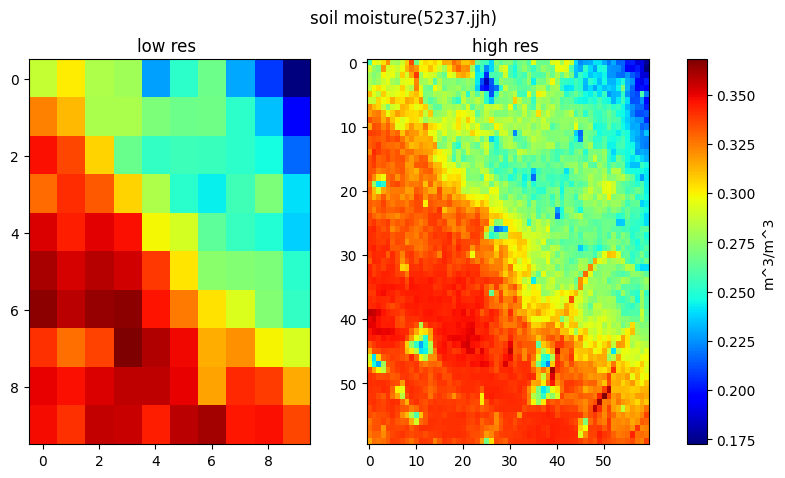

In [17]:
show_image()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lr = 3e-4
epochs = 15
batch_size = 16
num_workers = 1
img_channels = 1

cuda


In [19]:
import warnings
warnings.filterwarnings('ignore')
# listing the model to take the required subset of it
test_vgg_model = vgg19(weights=True).eval().to(device)
lf = list(test_vgg_model.features)
lf[:10]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [20]:
from torchvision.models import vgg19
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

In [21]:
import torch.nn as nn
class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(
            self,
            in_channels,
            out_channels,
            use_activation=True,
            use_BatchNorm=True,
            **kwargs
    ):
        
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = (
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2

In [22]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [27]:
# 生成器
class Generator(nn.Module):
    def __init__(self, in_channels=1, num_channels=64, num_blocks=16):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, num_channels, kernel_size=9, padding=4),
            nn.PReLU(num_channels)
        )

        self.res_blocks = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])

        self.conv_before_upsample = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_channels)
        )

        self.up1 = UpsampleBlock(num_channels, scale_factor=2)  # 10x10 -> 20x20
        self.up2 = UpsampleBlock(num_channels, scale_factor=2)  # 20x20 -> 40x40

        self.up3 = nn.Sequential(
            nn.Upsample(size=(60, 60), mode='bilinear', align_corners=True),
            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.PReLU(num_parameters=num_channels)
        )

        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels // 2, kernel_size=3, padding=1),
            nn.PReLU(num_channels // 2),
            nn.Conv2d(num_channels // 2, in_channels, kernel_size=9, padding=4)
        )

    def forward(self, x):
        initial = self.initial(x)

        res = self.res_blocks(initial)

        features = self.conv_before_upsample(res) + initial

        up1 = self.up1(features)
        up2 = self.up2(up1)
        up3 = self.up3(up2)

        return torch.sigmoid(self.final(up3))

In [28]:
# 判别器
class Discriminator(nn.Module):
    def __init__(self, in_channels, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx!= 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x


In [13]:
def plot_examples(gen):
    path = r"F:\Soil_moisture_dataset\Soil_moisture_dataset\Soil_moisture_dataset.h5"
    data_part = 'val'

    # 创建数据集实例
    dataset = ImageDataset(path, data_part)
    loader = DataLoader(dataset, batch_size=16, num_workers=1)

    # 创建一个figure，包含三个子图（低分辨率、预测的超分辨率、高分辨率）
    fig, axs = plt.subplots(1, 3 if gen is not None else 2, figsize=(8, 4))
    chosen_batch = np.random.randint(0, len(loader))
    for idx, (low_res, high_res) in enumerate(loader):
        if idx == chosen_batch:
            chosen = np.random.randint(0, len(low_res))

            # 展示低分辨率图像
            axs[0].set_axis_off()
            # 如果是张量，转换为numpy数组并调整维度顺序用于可视化（这里假设单通道图像情况）
            if torch.is_tensor(low_res):
                low_res_img = low_res[chosen].cpu().numpy().squeeze().transpose((1, 2, 0))
            else:
                low_res_img = low_res[chosen]
            axs[0].imshow(low_res_img, cmap='jet', aspect='auto')
            axs[0].set_title("low res")

            if gen is not None:
                print(2)
                with torch.no_grad():
                    # 将低分辨率数据放到合适的设备上并增加批次维度（如果需要），传入生成器获取预测的超分辨率图像
                    upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
                    # 将预测结果转换为numpy数组并调整维度用于可视化
                    upscaled_img = upscaled_img.cpu().numpy().squeeze().transpose((1, 2, 0))

                # 展示预测的超分辨率图像
                axs[1].set_axis_off()
                axs[1].imshow(upscaled_img, cmap='jet', aspect='auto')
                axs[1].set_title("predicted")

            # 展示高分辨率图像
            axs[-1].set_axis_off()
            if torch.is_tensor(high_res):
                high_res_img = high_res[chosen].cpu().numpy().squeeze().transpose((1, 2, 0))
            else:
                high_res_img = high_res[chosen]
            axs[-1].imshow(high_res_img, cmap='jet', aspect='auto')
            axs[-1].set_title("high res")

            break

    plt.show()
    gen.train()

In [17]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_progress(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(d_losses,label="Discriminator loss")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

In [18]:
gen = Generator(in_channels=1).to(device)
disc = Discriminator(in_channels=1).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

In [ ]:
# the data loaders for training and validation
# train = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/train")
# train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers)

# val = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
# val_loader = DataLoader(val, batch_size=batch_size, num_workers=num_workers)

path = r"F:\Soil_moisture_dataset\Soil_moisture_dataset\Soil_moisture_dataset.h5"
train_dataset = ImageDataset(path, 'train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
val_dataset = ImageDataset(path, 'val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
for idx, (low_res, high_res) in enumerate(train_loader):
    print(idx)
    print(low_res.shape)
    print(high_res.shape)
    print('*'*20)

In [22]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        
        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
        disc_loss = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()
        
        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

            
    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

In [ ]:
d_losses = []
g_losses = []
for epoch in range(epochs):
    plot_examples(gen)
    print("epoch ", epoch+1, "/", epochs)
    gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
    # train discriminator and generator and update losses
    d_losses.append(disc_loss)
    g_losses.append(gen_loss)

In [31]:
gen_save = Generator(in_channels=1).to(device)
gen_save.load_state_dict(torch.load("E:/Desktop/model/checkpoint1_gen"))
disc_save = Discriminator(in_channels=1).to(device)
disc_save.load_state_dict(torch.load("E:/Desktop/model/checkpoint1_disc"))
plot_examples(gen_save)

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "up1.conv.weight", "up1.conv.bias", "up1.ac.weight", "up2.conv.weight", "up2.conv.bias", "up2.ac.weight". 
	Unexpected key(s) in state_dict: "up1.up.0.weight", "up1.up.0.bias", "up1.up.2.weight", "up2.up.0.weight", "up2.up.0.bias", "up2.up.2.weight". 